# Rotation curve

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from scipy.integrate import solve_ivp
from astropy.io import ascii
from scipy import optimize
from scipy import interpolate
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import config as cfg
from galpy.potential.mwpotentials import MWPotential2014
from galpy.potential import TriaxialNFWPotential,PowerSphericalPotentialwCutoff,MiyamotoNagaiPotential
from galpy.potential import plotRotcurve
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import argrelextrema
import potential_classes as pot
%load_ext autoreload
%autoreload 2

r_schwa =  3.900118851984219e-10  kpc
/tmp/ipykernel_133517/664944167.py:39: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  v_Sof13=pd.read_csv('vel_Sofue13.txt', sep="  ")

/tmp/ipykernel_133517/664944167.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  v_Eilers = pd.read_csv('vel_Eilers.txt', sep="  ")

radio= 27.539965204377822  kpc
masa= 1.418792362179386  x10^11 solar masses
halo= <potential_classes.RAR object at 0x7fa118403d30>
halo.r[0]= 3.7937728597256774e-16
halo.r[-1]= 27.539965204377822
/home/mmestre/.conda/envs/cosmos/lib/python3.9/site-packages/galpy/potential/Potential.py:1147: RuntimeW

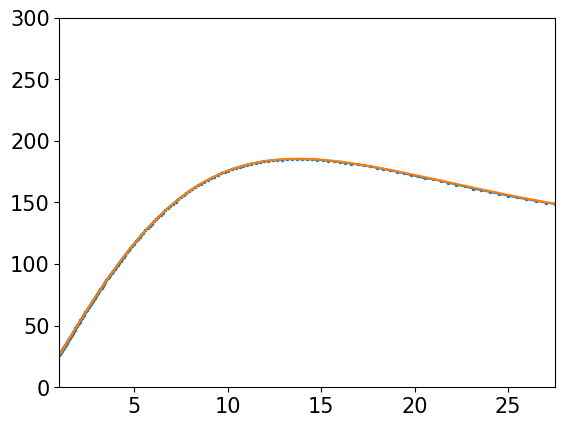

TypeError: can only concatenate str (not "float") to str

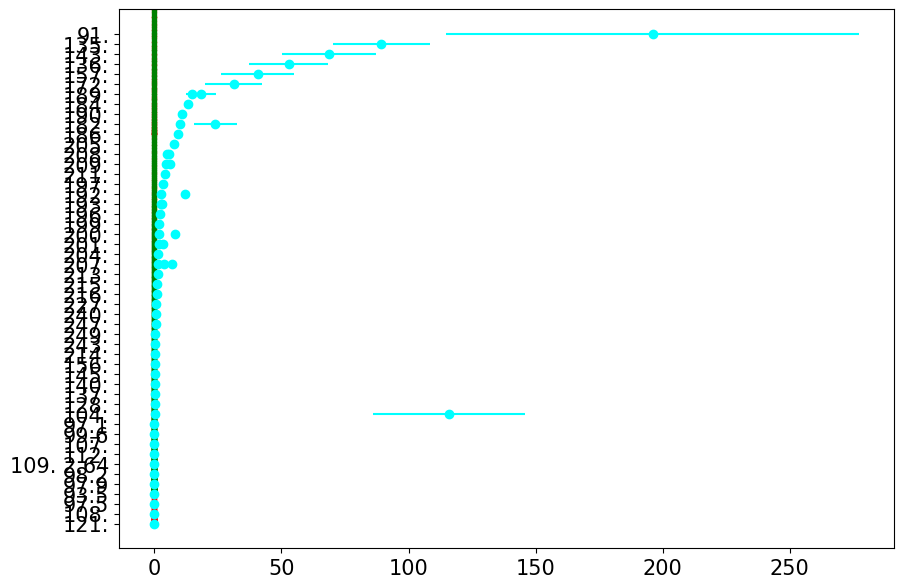

In [19]:
# Rotation velocity
G = 4.300923924e-6
c=2.997925e5  # km s^-1
kpc2cm = 3.0856776e+21 #cm/kpc
sec2rad = np.pi/(180.*60**2)
cm2kpc = 1.0/kpc2cm
M_bh = 4.075e6  # M_sun
r_schwa = 2.0*G*M_bh / c**2
print('r_schwa = ', r_schwa, ' kpc')

def accel_mw(x,y,z):
    return bulge.accel(x,y,z)+thin.accel(x,y,z)+thick.accel(x,y,z)+halo.accel(x,y,z)
    # return halo.accel(x,y,z)

def grad_mw(x,y,z):
    return -accel_mw(x,y,z)

def rot_vel_mw(r):
    return np.sqrt(r*(grad_mw(r,0,0)[0]))

def galpy_vcirc(r):
    mwp = MWPotential2014
    a= mwp[0].vcirc(r*u.kpc)
    b= mwp[1].vcirc(r*u.kpc)
    c= mwp[2].vcirc(r*u.kpc)
    return np.sqrt(a*a+b*b+c*c)*220.0

def malhan_vcirc(r):
    bp= PowerSphericalPotentialwCutoff(alpha=1.8,rc=1.9/8.,normalize=0.05)
    mp= MiyamotoNagaiPotential(a=3./8.,b=0.28/8.,normalize=.6)
    hp=TriaxialNFWPotential(a=16.0/8.,b=1.0,c=0.82,normalize=0.59)
    mw = bp+mp+hp
    v0=mw[0].vcirc(r*u.kpc)
    v1=mw[1].vcirc(r*u.kpc)
    v2=mw[2].vcirc(r*u.kpc)
    return np.sqrt(v0*v0+v1*v1+v2*v2)*220.0

# Set rotation data
v_Sof13=pd.read_csv('vel_Sofue13.txt', sep=" ")
v_Sof20=pd.read_csv('vel_Sofue20.txt', sep=" ")
v_Eilers = pd.read_csv('vel_Eilers.txt', sep="  ")
asym_error = [v_Eilers['e_down'], v_Eilers['e_up']]

# Set barionic potentials
M_gal=2.32e7  # Msun
bulge = pot.Plummer(460.0*M_gal,0.3)
thin = pot.MiyamotoNagai(1700.0*M_gal,5.3,0.25)
thick= pot.MiyamotoNagai(1700.0*M_gal,2.6,0.8)
# Changing the disk paramters according to "fit_pot-slice-barions_..."
# [alpha, scale, scaleb] = [1.082285264900089583e+00, 9.162718188400553743e-01, 9.006049804965896577e-01]
# thin = pot.MiyamotoNagai(1700.0*M_gal*alpha, 5.3*scale, 0.25*scaleb)
# thick = pot.MiyamotoNagai(1700.0*M_gal*alpha, 2.6*scale, 0.8*scaleb)
# u_0 = np.loadtxt(
#     '../pot_rot_barions_model/weight_1.0/antikythera/param_fit_pot-slice-rot-barions_from_IbataPolysGaiaDR2-data.txt')
# scales = u_0[2:8]
# scaleM_thin, scaleR_thin, scaleZ_thin = scales[0:3]
# scaleM_thick, scaleR_thick, scaleZ_thick = scales[3:6]
# thin = pot.MiyamotoNagai(1700.0*M_gal*scaleM_thin, 5.3*scaleR_thin, 0.25*scaleZ_thin)
# thick = pot.MiyamotoNagai(1700.0*M_gal*scaleM_thick, 2.6*scaleR_thick, 0.8*scaleZ_thick)

# Set halo potential
# ener_f = 60.0  # keV
# theta_0, W_0, beta_0 = 3.77780827e+01, 6.63468885e+01, 1.20446329e-05
# theta_0 = 3.555983357444605275e+01
# W_0 = theta_0 + 2.695065692279481695e+01
# theta_0 = 3.623511473208260014e+01
# W_0 = theta_0 + 2.745737545624503895e+01
# theta_0 = 3.595711139271328705e+01
# W_0 = theta_0 + 2.725291292672873666e+01
# beta_0 = 1.1977e-5
# beta_0 = 1.20446329e-05
# theta_0, d_theta = u_0[0:2]  # 3.801447492884311430e+01, 2.876435599599692239e+01
# beta_0 = 1.25e-5
# theta_0, d_theta = 3.617308965727325187e+01, 2.740902073407499984e+01
# theta_0, d_theta = 3.623511473208260014e+01, 2.745737545624503895e+01
# Values with factor 1/3 corrected:
# theta_0, d_theta = 3.628885544245152772e+01, 2.751120739351376443e+01 # antikythera
theta_0, d_theta = 3.622167561400048186e+01, 2.746168378720571113e+01 # serafin
theta_0, d_theta = 3.621802786938911822e+01, 2.745899649967862999e+01 # antikythera again
theta_0, d_theta, beta_0 = [36.602295138822136, 27.7389055636981, 1.2483866388197007e-5]
ener_f, theta_0, d_theta, beta_0 = [160.0, 38.41258742015278, 28.861437570475488, 0.00020341022881098476]
ener_f, theta_0, d_theta, beta_0 = [170.0, 38.659153030784545, 29.02076435108228, 0.00022642457481307425]
ener_f, theta_0, d_theta, beta_0 = [180.0, 38.659151633344315, 29.02076188196288, 0.00022625041108409515]
ener_f, theta_0, d_theta, beta_0 = [194.0, 38.79370150009697, 29.02297896106794, 0.0003434274129520655] 
ener_f, theta_0, d_theta, beta_0 = [218.0, 39.245315267007555, 29.234186274720873, 0.00048017706839641113]
ener_f, theta_0, d_theta, beta_0 = [222.9, 39.303649582651786, 29.250485799717634, 0.0005108313351863354]
ener_f, theta_0, d_theta, beta_0 = [218.7, 39.27071181080632, 29.246512183744002, 0.00048716591357873666]
ener_f, theta_0, d_theta, beta_0 = [225.9, 39.38071002753344, 29.287481537386633, 0.000532318353185992]
ener_f, theta_0, d_theta, beta_0 = [300.0, 40.65398721375036, 29.524719280317328, 0.0013010622429679916]

# List of solutions from GD-1 fit (Crests of maximums.)
# beta_0 = 1.0e-5
# theta_0, d_theta = 36.5310621242485, 27.687374749498996
# beta_0 = 1.2e-05
# theta_0, d_theta = 36.28657314629258, 27.494989979959918
# beta_0 = 1.3000000000000001e-05 
# theta_0, d_theta = 36.22244488977956, 27.442885771543086
# beta_0 =1.5e-05 
# theta_0, d_theta = 36.02204408817635, 27.286573146292586
W_0 = theta_0+d_theta
param = np.array([ener_f,theta_0, W_0, beta_0 ])  
halo = pot.RAR(param)
print('halo=',halo)
print('halo.r[0]=', halo.r_s[0])
print('halo.r[-1]=', halo.r_s[-1])

# Compute circular velocities
r_vec=np.logspace(np.log10(halo.r_s[0]),np.log10(halo.r_s[-1]),2000)
v_vec = [rot_vel_mw(x) for x in r_vec]
v_galpy = [galpy_vcirc(x) for x in r_vec]
v_malhan = [malhan_vcirc(x) for x in r_vec]
print('Rar: V_c(R_sun)=',rot_vel_mw(8.122))
print('Bovy: V_circ(R_sun)=', galpy_vcirc(8.122))
print('Malhan: V_circ(R_sun)=', malhan_vcirc(8.122))

def v_circ_Newton(r):
    """Newtonian circular velocity for the rar model."""
    G_u = 4.3009e-6  # kpc (km/s)^2 M_sun^-1
    return np.sqrt(G_u*halo.mass_wrap(r)/r)

def v_circ_Newton_array(r):
    """Newtonian circular velocity for the rar model."""
    G_u = 4.3009e-6  # kpc (km/s)^2 M_sun^-1
    return np.sqrt(G_u*halo.mass_wrap_array(r)/r)

def v_circ_GR(r):
    """GR circula velocity for the rar model. Better to use this one instead of the Newtonian."""
    c = 2.997925e5  # km s^-1
    return np.sqrt(0.5*c*c*r*halo.dnu_integral_spl(r))

def v_circ_GR_array(r):
    """GR circula velocity for the rar model. Better to use this one instead of the Newtonian."""
    c = 2.997925e5  # km s^-1
    return np.sqrt(0.5*c*c*r*halo.dnu_wrap_array(r))

def get_core(r):
    arg_max = argrelextrema(v_circ_GR_array(r), np.greater)
    print('arg_max=',arg_max)
    arg_first_max = arg_max[0][0]
    r_cand = r[arg_first_max]
    print('first max =', r_cand)
    print('second max =', r[arg_max[0][1]])
    bounds=np.array([r_cand*0.5,r_cand*1.5])
    r_core=optimize.fminbound(lambda r: -v_circ_GR(r),bounds[0],bounds[1],xtol=0.5e-12,maxfun=1000)
    m_core=halo.mass_spline(r_core)
    print('r_cand =', r_cand*cm2kpc)
    print('m_cand =', halo.mass_spline(r_cand))
    print('r_core =', r_core,' kpc')
    print('r_core =', r_core/r_schwa,' r_schwa')
    print('m_core =', m_core, ' M_sun')
    plt.plot(r, v_circ_GR_array(r), marker= '.', markersize=3)
    plt.plot(r, v_circ_Newton_array(r), marker='.', markersize=0.1 )
    # plt.xscale('log')
    # plt.yscale('log')
    print('r[-1]=', r[-1])
    plt.xlim(1,r[-1])
    plt.ylim(1.e-10,300)
    plt.show()
    return r_core, m_core

print('Newtonian')
get_core(r_vec)
v_vec_GR = [v_circ_GR(x) for x in r_vec]

# Plot
fig = plt.figure(figsize=(10,7))
font = {"size": 15}  
plt.rc('font', **font)
plt.scatter(r_vec,v_vec,s=8,marker='o', color='red', label='RAR+barions (fit)')
# plt.scatter(r_vec,v_galpy,s=8,marker='o', color='orange',label='MWPotential2014')
plt.scatter(r_vec,v_malhan,s=8,marker='o', color='green',label='Malhan+19 (fit)')
# plt.scatter(r_vec,v_circ_gr(r_vec), s=8,marker='o', color='violet',label='halo with dnu')
plt.errorbar(v_Sof13['r']/1.e3, v_Sof13['v'], xerr=v_Sof13['err_r']/1.e3 ,yerr=v_Sof13['err_v'], fmt='o', color='cyan', label='Sofue+13')
plt.errorbar(v_Sof20['Radius'],v_Sof20['Velocity'],yerr=v_Sof20['Error'],fmt='o',color='black',label='Sofue+20')
plt.errorbar(v_Eilers['r'],v_Eilers['v'],yerr=asym_error,fmt='o',color='blue',label='Eilers+19')
plt.scatter(r_vec,v_vec_GR,s=8,marker='.', color='black', label='DM (GR)')
plt.xlim(0,40)
plt.ylim(1.e-2,300)
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$v_r$ [km/s]')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
# plt.title(r'Rotation curve that fits GD-1 stream (RAR with $\beta_0=1.25\times 10^{-5}$)')
plt.savefig('plots/rotation_curves_data.png')

In [21]:
type(v_Sof13)

pandas.core.frame.DataFrame

(5.4453615721409266e-17, 191.87040413384307)

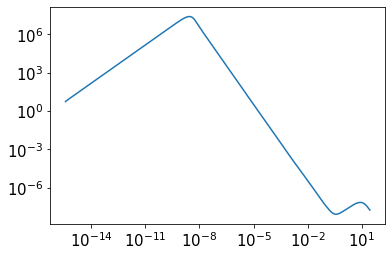

In [10]:
dnu1=halo.dnu_wrap_array(halo.r_s)
dnu2=halo.dnu_integral_spl(halo.r_s)
plt.plot(halo.r_s,dnu1)
#plt.plot(halo.r_s,dnu2, color='black')
plt.xscale("log")
plt.yscale("log")
plt.xlim(None,None)